In [30]:
def generate_drw(baseline, t):
    num_samples = len(t)
    tau = np.random.uniform(baseline/1000, baseline*15)
    print("DRW tau=" + str(tau))
    log_a = -1.6  # Lower bound (log scale)
    log_b = -0.25  # Upper bound (log scale)
    log_sigma = np.random.uniform(log_a, log_b, size=1)
    # Generate random values from the log-uniform distribution
    sigma = np.exp(log_sigma)
    print("DRW sigma=" + str(sigma))
    
    # Generate the PSD for the DRW
    frequencies = np.fft.fftfreq(len(t), baseline/num_samples)
    # print("Frequencies=" + str(frequencies))
    fft_numerator = 4*tau 
    fft_denominator = 1 + (2 * np.pi * frequencies * tau) ** 2
    psd = sigma ** 2 * fft_numerator / fft_denominator

    # DRW in Frequency domain
    noise = np.random.randn(len(t)) / np.sqrt(len(t))
    fft_drw = np.sqrt(psd) * noise
    # print("len=" + str(len(t)) + " sqrt=" + str(np.sqrt(len(t))) + " noise=" + str(noise))
    # print("psd=" + str(psd))
    # print("psd_with_noise=" + str(fft_drw))

    # Convert back to time domain and take the magnitude of the complex numbers
    drw = np.abs(np.fft.ifft(fft_drw) * len(t))
    #print("drw=" + str(drw))
    return drw

#print(str(generate_drw(LSST,  list(range(1, LSST.observation_period, LSST.cadence)))))

In [31]:
import random
import numpy as np

def generate_light_curve(survey, is_binary):
    
    # Observations have certain cadence. e.g. expected to be every ~7 days for LSST. Therefore,
    baseline = survey.observation_period
    t = np.arange(0, baseline, survey.cadence)
    # 7 days cadence is not exact, so add Gaussian noise with sigma = 1 day (for LSST) to the observation days
    cadence_dev = np.random.normal(survey.cadence, survey.cadence_deviation, len(t))
    t = t + cadence_dev

    # Generate the damped random walk signal
    drw = generate_drw(baseline, t)

    # Sum the DRW and sinusoidal signals
    if is_binary:
        # amplitude of sinusoidal signal
        amplitude = random.uniform(0.05, 0.5) 
        print("sinusoidal signal amplitude=" + str(amplitude))
    
        # period of binary between 30 days to 10 yrs
        period = random.uniform(30, survey.observation_period)
        print("sinusoidal signal period=" + str(period))

        # Generate sinusoidal signal for binary
        phase = np.random.uniform(0, 2 * np.pi)
        print("Sin Phase=" + str(phase))

        sinusoid = amplitude * np.sin((2 * np.pi * (t - t[0]) / period) + phase)

        drw_sine = drw + sinusoid
    else:
        drw_sine = drw
        
    # Add gaussian noise to simulate photometric error
    errors = np.random.normal(0, survey.photometric_error, len(t))
    drw_sine = drw_sine + errors

    # wipe off about 6 months signal every year due to simulate gaps in observation
    drw_sine_with_gaps = []
    t_with_gaps = []
    gap_start = random.uniform(1,  365 - survey.gap_period)
    gap_end = gap_start + survey.gap_period
    for x in range(0, len(t)):
        if ((t[x] % 365) < gap_start or (t[x] % 365) >= gap_end):
            drw_sine_with_gaps.append(drw_sine[x])
            t_with_gaps.append(t[x])
    print("total num observations=" + str(len(t_with_gaps)))
 
    # add simulated error bars
    signal_error = np.full_like(drw_sine_with_gaps, survey.photometric_error)

    return (t_with_gaps, drw_sine_with_gaps, signal_error, t, drw, sinusoid)

In [32]:
from dataclasses import dataclass
@dataclass(frozen=True)
class SurveyParams:
    observation_period: float
    cadence: float
    cadence_deviation: float
    photometric_error: float
    gap_period: float

# Parameters for different surveys, to be confirmed
LSST = SurveyParams(observation_period = 10 * 365, cadence = 7, cadence_deviation = 1, photometric_error = 0.01, gap_period = 182)
CRTS = SurveyParams(observation_period = 7 * 365, cadence = 20, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182)
IMLT = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182) 
AXIS = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182)

DRW tau=10602.830077568513
DRW sigma=[0.35306634]
sinusoidal signal amplitude=0.3596541000837501
sinusoidal signal period=2293.4983597130467
Sin Phase=0.35552154120153057
total num observations=260


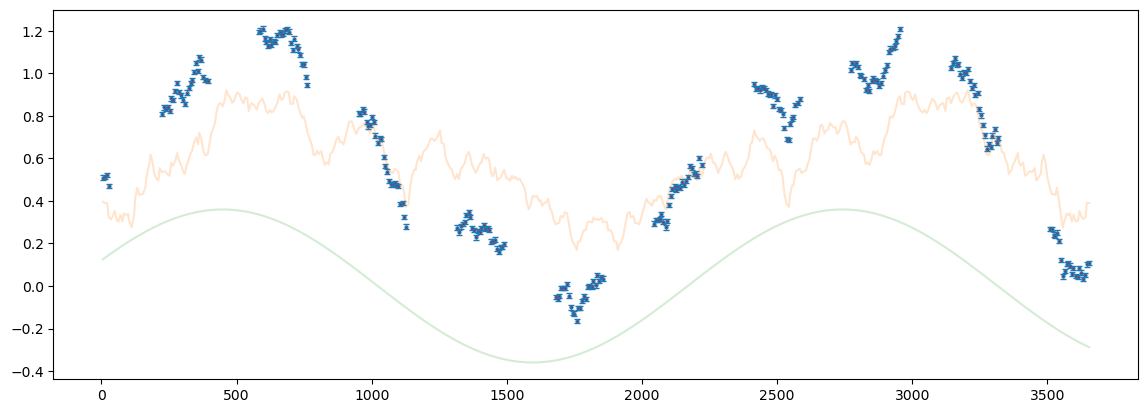

In [33]:
# main function
import matplotlib.pyplot as plt
import math

is_binary = True
light_curve = generate_light_curve(LSST, is_binary) #  generateFixedSample / generateRandomSample(LSST) 
plt.figure().set_figwidth(14)
plt.errorbar(light_curve[0], light_curve[1], yerr=light_curve[2], fmt='o', ms=2, mfc='red', lw=0.5,capsize=2, mouseover=True)
plt.plot(light_curve[3], light_curve[4], alpha=0.2)
if is_binary:
    plt.plot(light_curve[3], light_curve[5], alpha=0.2)

plt.show()